<a href="https://colab.research.google.com/github/aliahmad-rahmani/Face-Detection-and-Alignment/blob/main/Face_Alignment_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!pip install mtcnn

In [13]:
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math


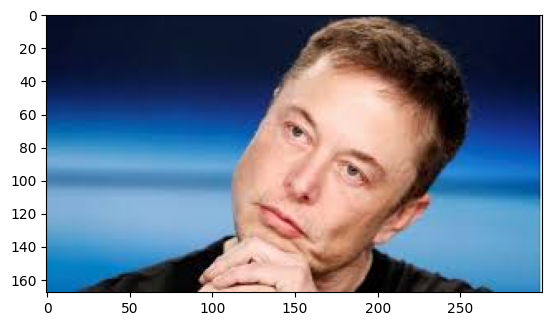

In [14]:
face_detector = MTCNN()

# load image from file
img = plt.imread('/content/drive/MyDrive/Elon-align.jpg')
plt.imshow(img)
plt.show()

In [15]:
# draw an image with detected objects
def draw_facebox_and_keypoints(filename, result_list):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = plt.Rectangle((x, y), width, height,fill=False, color='orange')
        # draw the box
        ax.add_patch(rect)
        # draw the dots
        for key, value in result['keypoints'].items():
            # create and draw dot
            dot = plt.Circle(value, radius=2, color='red')
            ax.add_patch(dot)
            # show the plot
    plt.show()# filename = 'test1.jpg' # filename is defined above, otherwise uncomment

1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 168ms/step


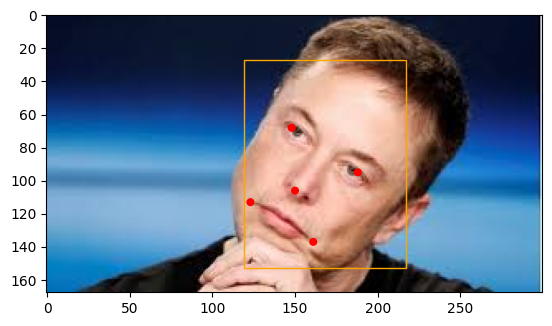

In [16]:
results = face_detector.detect_faces(img)

draw_facebox_and_keypoints('/content/drive/MyDrive/Elon-align.jpg', results)

In [17]:
def EuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [18]:
def alignment_procedure(img, left_eye, right_eye):

    #this function aligns given face in img based on left and right eye coordinates

    left_eye_x, left_eye_y = left_eye
    right_eye_x, right_eye_y = right_eye

    #-----------------------
    #find rotation direction

    if left_eye_y > right_eye_y:
        point_3rd = (right_eye_x, left_eye_y)
        direction = -1 #rotate same direction to clock
    else:
        point_3rd = (left_eye_x, right_eye_y)
        direction = 1 #rotate inverse direction of clock

    #-----------------------
    #find length of triangle edges

    a = EuclideanDistance(np.array(left_eye), np.array(point_3rd))
    b = EuclideanDistance(np.array(right_eye), np.array(point_3rd))
    c = EuclideanDistance(np.array(right_eye), np.array(left_eye))

    #-----------------------

    #apply cosine rule

    if b != 0 and c != 0: #this multiplication causes division by zero in cos_a calculation

        cos_a = (b*b + c*c - a*a)/(2*b*c)
        angle = np.arccos(cos_a) #angle in radian
        angle = (angle * 180) / math.pi #radian to degree

        #-----------------------
        #rotate base image

        if direction == -1:
            angle = 90 - angle

        img = Image.fromarray(img)
        img = np.array(img.rotate(direction * angle))

    #-----------------------

    return img #return img anyway

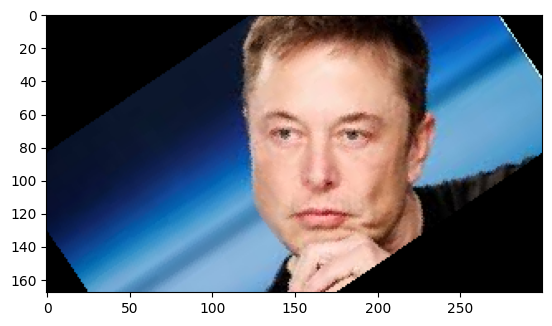

In [19]:
detection = results[0]
keypoints = detection["keypoints"]
left_eye = keypoints["left_eye"]
right_eye = keypoints["right_eye"]

img = alignment_procedure(img, left_eye, right_eye)

plt.imshow(img)

In [20]:
src = np.array([
       [  54.70657349,   73.85186005],
       [ 105.04542542,   73.57342529],
       [  80.03600311,  102.48085785],
       [  59.35614395,  131.95071411],
       [ 101.04272461,  131.72013855]], dtype=np.float32)

landmark = np.array([results[0]['keypoints']['left_eye'],\
            results[0]['keypoints']['right_eye'],\
            results[0]['keypoints']['nose'],\
            results[0]['keypoints']['mouth_left'],\
            results[0]['keypoints']['mouth_right']])

In [21]:
from skimage import transform as trans

dst = landmark.astype(np.float32)
tform = trans.SimilarityTransform()
tform.estimate(dst, src)
M = tform.params[0:2,:]
M

array([[   0.90412474,    0.56908412, -118.26877489],
       [  -0.56908412,    0.90412474,   96.50621202]])

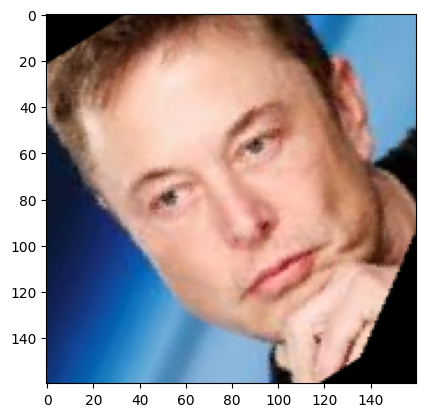

In [22]:
import cv2
wrapped = cv2.warpAffine(img,M,(160,160), borderValue = 0.0)
plt.imshow(wrapped)
plt.show()